# Detecting Malaria Parasitized Cell

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import helper
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_transforms = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

## Getting The Required Data For Training
#### The Data Consists Of two classes Parasitized and Uninfected

In [3]:
import torchvision.datasets as datasets

In [4]:
train_dataset = datasets.ImageFolder(root='dataset/cell-images-for-detecting-malaria/train',transform=train_transforms)

In [5]:
train_dataset.classes

['Parasitized', 'Uninfected']

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)

In [7]:
batch = next(iter(train_loader))
images, labels = batch

# Visualising Images To Understand Data

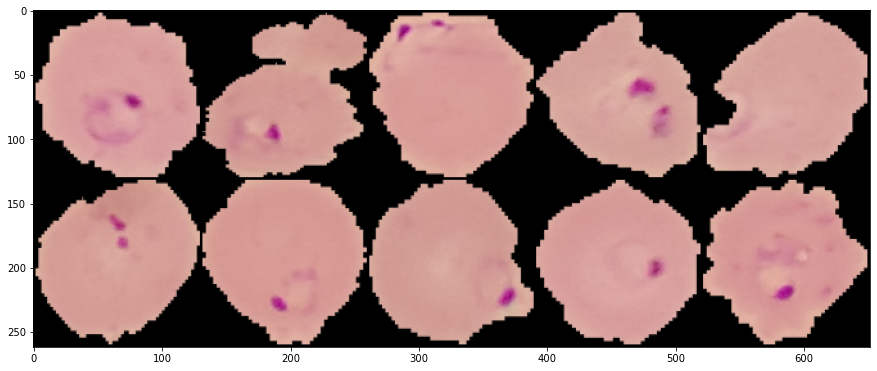

In [8]:
grid = torchvision.utils.make_grid(images[:10], nrow=5)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

## Creating Model 

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net,self).__init__() 
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=512,kernel_size=3)

        self.fc1 = nn.Linear(in_features=512*14*14, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=512)
        self.out = nn.Linear(in_features=512, out_features=2)
        

    def forward(self, t):

        t = t
        
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)


        t = t.reshape(-1,512*14*14)  
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.out(t)
        
        return t



### Helper Function to get the total correct predictions from model

In [11]:
def get_num_correct(preds, labels): 
    return preds.argmax(dim=1).eq(labels).sum().item()

In [12]:
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

## Training Our Model

In [13]:
import torch.optim as optim

In [14]:
network_object = Net()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
optimizer = optim.Adam(network_object.parameters(), lr=0.0005) # network parameters are the weights

for epoch in range(3):

    total_loss = 0
    total_correct = 0

    for batch in train_loader:

        images, labels = batch  
        
        preds = network_object(images)  
        loss = F.cross_entropy(preds,labels)

        optimizer.zero_grad() 

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_num_correct(preds,labels)


    print('Epoch: ',epoch,' Total Correct: ',total_correct, 'Loss: ',total_loss, ' Percentage Correct: ',total_correct/len(train_dataset))

Epoch:  0  Total Correct:  27137 Loss:  535.1776882821146  Percentage Correct:  0.9847231293998113
Epoch:  1  Total Correct:  24237 Loss:  215.33727256144044  Percentage Correct:  0.8794905290659699
Epoch:  2  Total Correct:  25960 Loss:  974.2584439009057  Percentage Correct:  0.942013208505697


## Testing Our Model

In [28]:
test_dataset = datasets.ImageFolder(root='dataset/cell-images-for-detecting-malaria/test',transform=train_transforms)

In [30]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

In [31]:
classes = ['Parasitized', 'Uninfected']

In [37]:
def test_score():

    test_loss = torch.zeros(1)
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    criterion = nn.CrossEntropyLoss()

    network_object.eval()

    for batch_i, data in enumerate(test_loader):

        inputs, labels = data
        outputs = network_object(inputs)
        loss = criterion(outputs, labels)

        test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
        _, predicted = torch.max(outputs.data, 1)
        correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

        for i in range(20):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

    for i in range(2):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% ' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: ' % (classes[i]))


    print('\nTest Accuracy (Overall): %2d%% ' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [35]:
test_score()

Test Loss: 34.607849
Test Accuracy of Parasitized:  90% 
Test Accuracy of Uninfected: 95% 
Test Accuracy (Overall): 93% 


# Conclusion

### The model performs well on test data with high accuracy and less loss